In [160]:
import os
import shutil
import random
import uuid
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, MaxPooling2D, Conv2D, Flatten, Input
from tensorflow.keras.metrics import Precision, Recall

## Set GPU Growth

In [161]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## Create Folder Structures

In [162]:
POS_PATH = os.path.join('data' ,'positive' )
NEG_PATH = os.path.join('data' ,'negative')
ANC_PATH = os.path.join('data' , 'anchor')

In [163]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

## Uncompress dataset, move to our data folder

In [ ]:
# mount google_drive on colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# move our data to working dir of notebook file on colab
!cp /content/drive/MyDrive/DIP_faceRec/* .
!unzip Archive.zip
!cp anchor/* data/anchor/
!cp positive/* data/positive/

In [36]:
# uncompress dataset
!tar -xf lfw.tgz

In [37]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [38]:
# remove lfw dir since we moved its content to our data folder
# specify the directory name
lfw_path = 'lfw'

# check if the directory exists
if os.path.exists(lfw_path):
    try:
        # remove the directory and all its contents
        shutil.rmtree(lfw_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (lfw_path, e))
else:
    print('Directory does not exist:', lfw_path)

## Collect Anchor, Positive images using webcam

In [39]:
# Tip: you need to collect about 300-400 images for both anchor and positive

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[200:450,200:450,:]
    cv2.imshow('Image Collection', frame)
    key = cv2.waitKey(1)
    if key == ord("a"):
        imgName = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgName, frame)
    if key == ord("p"):
        imgName = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgName, frame)
    if key == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

In [8]:
frame.shape

(250, 250, 3)

## Data Augmentation

In [18]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [19]:
# Augment only original anchor images
for file_name in os.listdir(os.path.join(ANC_PATH)):
    if not file_name.startswith('aug_'):  # Skip already augmented images
        img_path = os.path.join(ANC_PATH, file_name)
        img = cv2.imread(img_path)
        augmented_images = data_aug(img)
        for image in augmented_images:
            aug_img_name = 'aug_{}.jpg'.format(uuid.uuid1())
            cv2.imwrite(os.path.join(ANC_PATH, aug_img_name), image.numpy())

        # rename the original image to indicate it has been augmented
        os.rename(img_path, os.path.join(ANC_PATH, 'aug_' + file_name))

# Augment only original positive images
for file_name in os.listdir(os.path.join(POS_PATH)):
    if not file_name.startswith('aug_'):  # Skip already augmented images
        img_path = os.path.join(POS_PATH, file_name)
        img = cv2.imread(img_path)
        augmented_images = data_aug(img)
        for image in augmented_images:
            aug_img_name = 'aug_{}.jpg'.format(uuid.uuid1())
            cv2.imwrite(os.path.join(POS_PATH, aug_img_name), image.numpy())

        # rename the original image to indicate it has been augmented
        os.rename(img_path, os.path.join(POS_PATH, 'aug_' + file_name))

## Preprocess

In [164]:
# Function to preprocess the images
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)   # Read img
    img = tf.io.decode_jpeg(byte_img)       # Load img
    img = tf.image.resize(img, (100, 100))  # Resize
    img = img / 255.0                       # Normalization
    return img

In [165]:
# Function to preprocess twin images
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

## Data Partition

In [166]:
# Load data
anchor = tf.data.Dataset.list_files(f"{ANC_PATH}{os.sep}*jpg").take(300)
positive = tf.data.Dataset.list_files(f"{POS_PATH}{os.sep}*jpg").take(300)
negative = tf.data.Dataset.list_files(f"{NEG_PATH}{os.sep}*jpg").take(300)

In [167]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [168]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [169]:
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [170]:
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [171]:
test_batch = train_data.as_numpy_iterator()

In [172]:
batch_1 = test_batch.next()

In [173]:
X = batch_1[:2]

In [174]:
y = batch_1[2]

In [175]:
y

array([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

## Model

In [176]:
# Siamese L1 Distance class
# this is a custom layer that we added to our siamese network to calc distance between features
# NOTE: make sure that you load this layer in custom objects if you Reload model weights
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [177]:
# Function to make the embedding model
def make_embedding():
    """
    extract features from images
    """
    inp = Input(shape=(100,100,3),name='input_image')

    #first iteration
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #2nd iteration
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #3rd iteration
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #final iteration
    c4 = Conv2D(256 ,(4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [178]:
embedding = make_embedding()

In [179]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 46, 46, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 20, 20, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

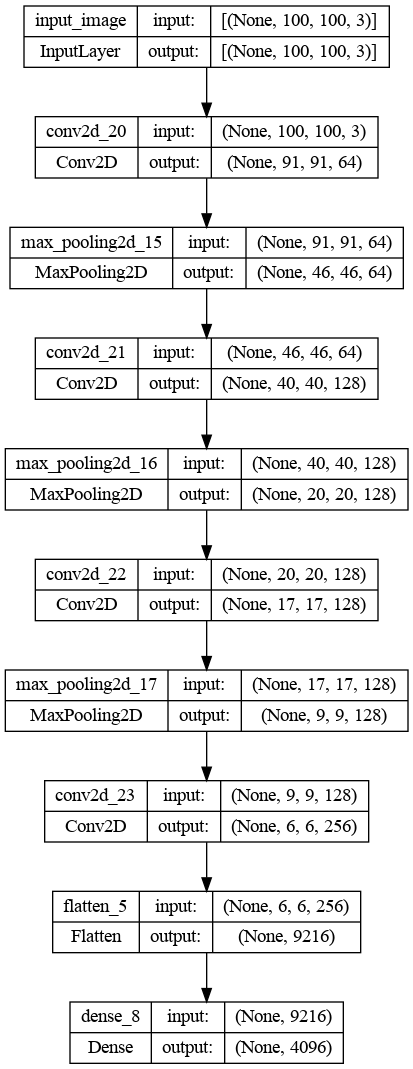

In [180]:
tf.keras.utils.plot_model(embedding, show_shapes=True)

In [181]:
# Function to make the siamese model
def make_siamese_model():
    """
    apply embedding on both input_img and validation_img to extract features,
    calc distance between each feature,
    based on a custom threshold for the distance verify if they are similer
    """
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    # combine distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    # Return the model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [182]:
siamese_model = make_siamese_model()

In [183]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

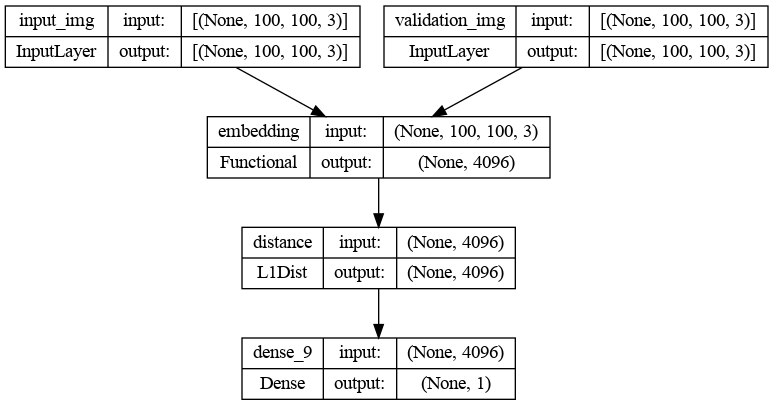

In [184]:
tf.keras.utils.plot_model(siamese_model, show_shapes=True)

## Training

In [185]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [219]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [220]:
# Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [221]:
# Train step function
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        y_pred = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, y_pred)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [222]:
# Training Loop

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            progbar.update(idx+1)
        
        print("loss:", loss.numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [223]:
# Train model
EPOCHS = 20
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 38s 1s/step
loss: 0.019736925

 Epoch 2/20
27/27 [==============================] - 41s 2s/step
loss: 0.107802786

 Epoch 3/20
27/27 [==============================] - 41s 2s/step
loss: 0.004584917

 Epoch 4/20
27/27 [==============================] - 41s 2s/step
loss: 5.602881e-06

 Epoch 5/20
27/27 [==============================] - 42s 2s/step
loss: 0.05060973

 Epoch 6/20
27/27 [==============================] - 41s 2s/step
loss: 0.0024922655

 Epoch 7/20
27/27 [==============================] - 41s 2s/step
loss: 0.0013477025

 Epoch 8/20
27/27 [==============================] - 41s 2s/step
loss: 0.5602484

 Epoch 9/20
27/27 [==============================] - 41s 2s/step
loss: 0.0001090527

 Epoch 10/20
27/27 [==============================] - 41s 2s/step
loss: 0.037187096

 Ep

## Evaluation

In [224]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [225]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 444ms/step


array([[1.3634466e-05],
       [1.0000000e+00],
       [1.6062988e-04],
       [9.9995869e-01],
       [1.0000000e+00],
       [8.9712776e-05],
       [9.9900556e-01],
       [9.9853462e-01],
       [1.3983648e-06],
       [9.9999648e-01],
       [1.0070109e-05],
       [1.1232509e-03],
       [6.5526223e-07],
       [9.9206805e-01],
       [1.0000000e+00],
       [9.9999857e-01]], dtype=float32)

In [226]:
# Post processing the results
predictions = [1 if prediction > 0.5 else 0 for prediction in y_hat]

print("predictions:", predictions)
print("actual_labels:", y_true)

predictions: [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
actual_labels: [0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.]


In [227]:
# Calculate recall
recall = Recall()                           # Creating a metric object
recall.update_state(y_true, y_hat)          # Calculating the recall value
recall_result = recall.result().numpy()     # Return Recall Result

print("recall_result:", recall_result)

recall_result: 1.0


In [228]:
# Calculate precision
precision = Precision()
precision.update_state(y_true, y_hat)
precision_result = precision.result().numpy()

print("precision_result:", precision_result)

precision_result: 1.0


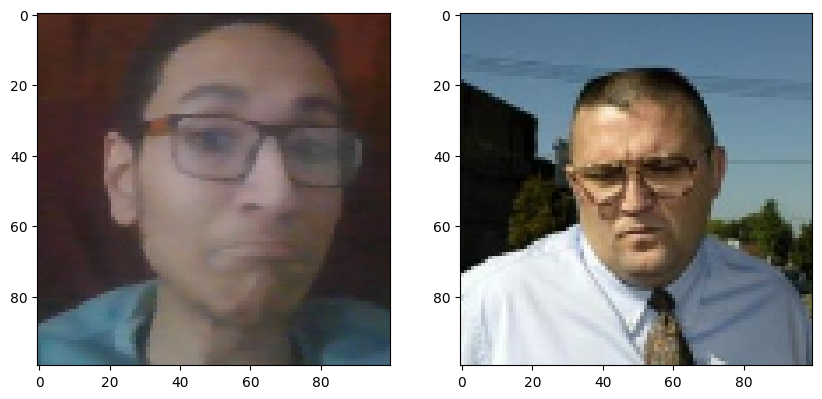

In [231]:
# Plot the test images and predictions

# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

## Save Model

In [232]:
# Save weights
siamese_model.save('siamese_model.h5')

## Reload Model

In [233]:
model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Dist':L1Dist})

In [205]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [234]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 537ms/step


array([[1.3634466e-05],
       [1.0000000e+00],
       [1.6062988e-04],
       [9.9995869e-01],
       [1.0000000e+00],
       [8.9712776e-05],
       [9.9900556e-01],
       [9.9853462e-01],
       [1.3983648e-06],
       [9.9999648e-01],
       [1.0070109e-05],
       [1.1232509e-03],
       [6.5526223e-07],
       [9.9206805e-01],
       [1.0000000e+00],
       [9.9999857e-01]], dtype=float32)

## Real Time Verification

In [207]:
# create app_data folder which will store input_image, verification_images
INPUT_IMG_PATH = os.path.join('app_data', 'input_image')
VERIFICATION_IMGS_PATH = os.path.join('app_data', 'verification_images')
os.makedirs(INPUT_IMG_PATH, exist_ok=True)
os.makedirs(VERIFICATION_IMGS_PATH, exist_ok=True)

In [208]:
# copy random subset of positive images to be used as verification_images

# Define the paths to your anchor and positive image folders
POSITIVE_IMGS_PATH = os.path.join('data', 'positive')

# Get a list of all positive images
positive_images = os.listdir(POSITIVE_IMGS_PATH)

# Clear the verification_images folder
for filename in os.listdir(VERIFICATION_IMGS_PATH):
    file_path = os.path.join(VERIFICATION_IMGS_PATH, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# Define the number of images you want to copy
num_images_to_copy = 50  # Adjust this value as needed

# Randomly select a subset of positive images
selected_positive_images = random.sample(positive_images, num_images_to_copy)

# Copy the selected images to the verification_images folder
for image in selected_positive_images:
    shutil.copy(os.path.join(POSITIVE_IMGS_PATH, image), VERIFICATION_IMGS_PATH)

In [209]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    
    for image in os.listdir(os.path.join('app_data', 'verification_images')):
        input_img = preprocess(os.path.join('app_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('app_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('app_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [210]:
# Function to perform real-time verification
def real_time_verification(model, detection_threshold, verification_threshold):
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        ret, frame = cap.read()
        frame = frame[120:120+250, 200:200+250, :]

        cv2.imshow('Verification', frame)

        # Store the key pressed
        key = cv2.waitKey(1) & 0xFF

        # Verification trigger
        if key == ord('v'):
            # Save input image to app_data/input_image folder
            cv2.imwrite(os.path.join('app_data', 'input_image', 'input_image.jpg'), frame)
            # Run verification
            results, verified = verify(model, detection_threshold, verification_threshold)
            print(verified)
            print(results)

        if key == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [239]:
# Set the detection and verification thresholds
detection_threshold = 0.999
verification_threshold = 0.7

In [240]:
# Start real-time verification
real_time_verification(model, detection_threshold, verification_threshold)

1/1 [==============================] - 0s 48ms/step
True
[array([[1.]], dtype=float32), array([[0.9999998]], dtype=float32), array([[0.36642352]], dtype=float32), array([[0.99999326]], dtype=float32), array([[0.99999994]], dtype=float32), array([[0.9999999]], dtype=float32), array([[0.99999744]], dtype=float32), array([[0.99999994]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[0.9999998]], dtype=float32), array([[0.9999415]], dtype=float32), array([[0.9716792]], dtype=float32), array([[1.]], dtype=float32), array([[1.]], dtype=float32), array([[0.99992687]], dtype=float32), array([[0.97773534]], dtype=float32), array([[0.99999994]], dtype=float32), array([[0.9999896]], dtype=float32), array([[1.]], dtype=float32), array([[0.9962732]], dtype=float32), array([[1.]], dtype=float32), array([[0.9810118]], dtype=float32), array([[0.99